In [15]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import tf_keras as keras # need keras 2 to fit Lattice model
from tf_keras.models import Sequential, Model
from tf_keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from tf_keras.constraints import Constraint
from tf_keras.callbacks import EarlyStopping
from tf_keras.initializers import Zeros, Constant
from tf_keras.optimizers import Adam, Nadam, RMSprop
from tf_keras.models import clone_model
import keras_tuner as kt
from tf_keras import backend as K
from tf_keras import regularizers
from tf_keras.utils import plot_model
from tf_keras.losses import Poisson, Loss
from tf_keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [16]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [17]:
#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_low_var.csv")

In [18]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,0.855910,-0.977807,0.070514,0.247397,-0.844805,-0.633014,0.932805,269.727579
1,0.430379,-0.917687,-0.577348,0.805874,-0.996460,0.808088,-0.727145,0.592222,0.416902,0.949203,606.423722
2,0.205527,0.846601,-0.046190,-0.144766,-0.689890,0.004793,0.787168,-0.029304,-0.254262,-0.739165,6740.904922
3,0.089766,-0.187530,-0.835531,0.021611,-0.366478,-0.798260,-0.363850,0.669637,-0.150974,0.020263,6749.592779
4,-0.152690,0.888564,-0.524681,0.166400,0.303690,0.055164,0.158018,0.046901,-0.468522,-0.772319,79.024055
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,-0.723110,0.451842,-0.547824,0.165682,-0.515032,0.372611,-0.262674,30.561326
19996,-0.403467,0.989823,-0.239838,0.690306,0.015041,0.168038,-0.808643,-0.903895,-0.433667,-0.389854,105.129106
19997,-0.107088,0.176448,-0.661992,0.568246,0.620266,0.669292,-0.267906,0.006409,0.871063,-0.570751,1101.252426
19998,-0.279747,-0.150770,-0.472139,0.238510,0.102065,-0.832383,0.539168,0.073274,0.110462,-0.408447,634.928937


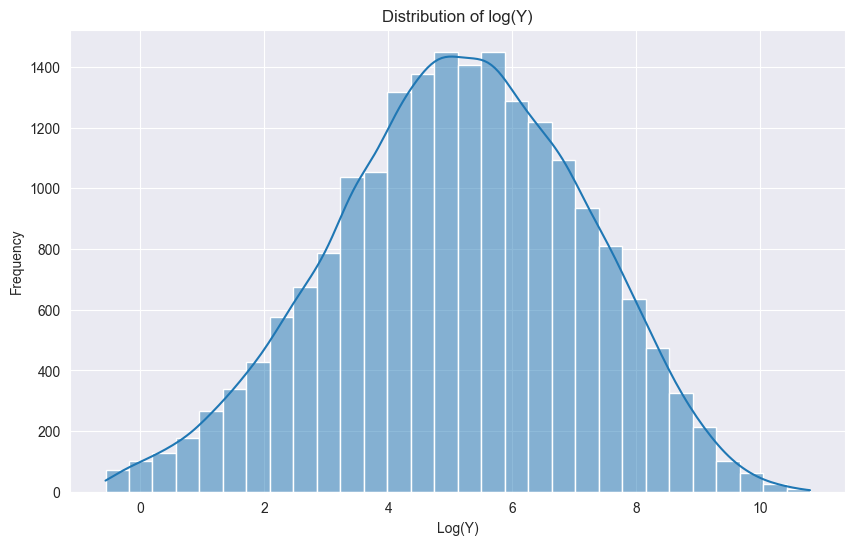

In [19]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [20]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
all_vars.remove(target_var) # store all input features
cat_vars = [] # categorical features
smooth_vars = ["X1","X2"]

In [21]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[all_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [22]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

In [23]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 100
num_layers_main = 5
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"X3" : "decreasing"} # either "increasing", "decreasing", or "none"

# main effect
for name in all_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
        sub_outputs_main.append(mean_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        sub_outputs_main.append(mean_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# combine subnets' outputs
main_subnets = Concatenate(name = "subnet_output")(sub_outputs_main)
final_output = Dense(1, activation = "exponential", name = "final_output")(main_subnets)

# final model
model_main_effect = Model(inputs = inputs, outputs = final_output)

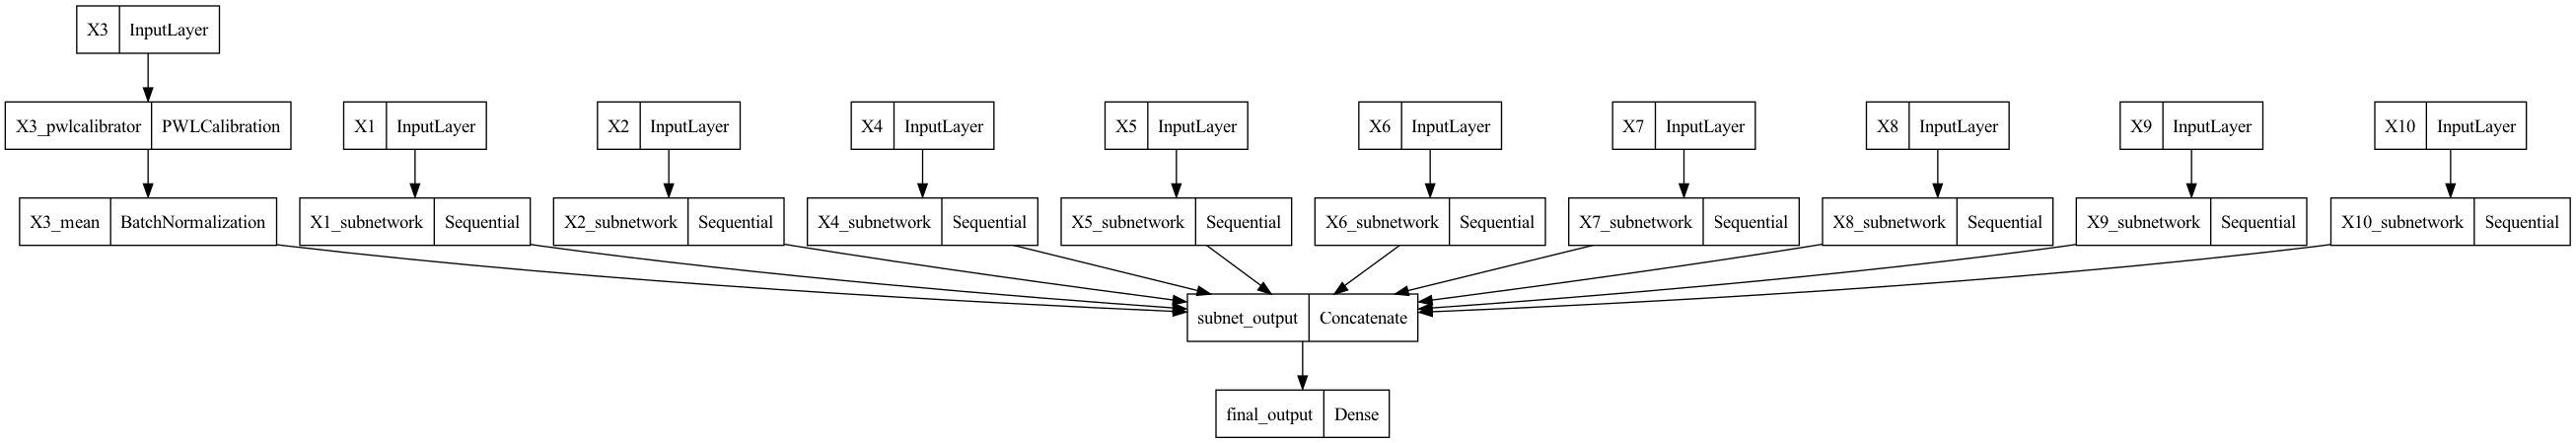

In [24]:
plot_model(model_main_effect)

In [25]:
# -------------------------- define loss function --------------------------
# we will use a Gamma loss function
def gamma_nll(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-7, 1e30)
    loss = K.mean(y_true/y_pred - K.log(y_true/y_pred))
    return loss

In [26]:
# -------------------------- add smoothness penalty --------------------------
subnet_layer = model_main_effect.get_layer("subnet_output")
subnet_model = Model(inputs = model_main_effect.inputs, outputs = subnet_layer.output)
subnet_weights = model_main_effect.get_layer("final_output").get_weights()[0]
lambd = 0.2
grid_length = 1000

def make_smoothness_penalty(var):

    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(X_train[var].min(), dtype=tf.float32)
    grid_max = tf.constant(X_train[var].max(), dtype=tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in all_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the subnet model's output
        f = subnet_model(grid_inputs)[:, all_vars.index(var)]*subnet_weights[all_vars.index(var)][0]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Calculate the second derivative using finite differences
        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2

        # Compute finite differences
        f_plus = f[2:]      # f(x + h)
        f_minus = f[:-2]    # f(x - h)
        f_current = f[1:-1] # f(x)

        # Second derivative approximation
        second_derivative = (f_plus + f_minus - 2 * f_current) / h_squared

        # Compute the penalty
        penalty = lambd * K.mean(K.abs(second_derivative))
        return penalty
    return smoothness_penalty

for var in smooth_vars:
    penalty_function = make_smoothness_penalty(var)
    model_main_effect.add_loss(penalty_function)

In [27]:
# -------------------------- fit the model --------------------------
# create training & validation data consistent with the model architecture
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])
    X_test_split.append(X_test.iloc[:, i])

# compile and fit
model_main_effect.compile(optimizer = "rmsprop", 
                        loss = gamma_nll,
                          metrics = [gamma_nll, RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 20)
%time hist_main = model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
12/12 [==============================] - 5s 91ms/step - loss: 1020.5408 - gamma_nll: 1017.3978 - root_mean_squared_error: 2396.8667 - val_loss: 749.9213 - val_gamma_nll: 749.7519 - val_root_mean_squared_error: 2619.4341
Epoch 2/5000
12/12 [==============================] - 0s 29ms/step - loss: 625.4535 - gamma_nll: 625.4912 - root_mean_squared_error: 2397.0674 - val_loss: 716.7855 - val_gamma_nll: 716.6010 - val_root_mean_squared_error: 2619.4148
Epoch 3/5000
12/12 [==============================] - 0s 31ms/step - loss: 539.8963 - gamma_nll: 539.5415 - root_mean_squared_error: 2396.9856 - val_loss: 682.5302 - val_gamma_nll: 682.3394 - val_root_mean_squared_error: 2619.3926
Epoch 4/5000
12/12 [==============================] - 0s 28ms/step - loss: 501.0632 - gamma_nll: 500.7185 - root_mean_squared_error: 2396.8757 - val_loss: 641.6932 - val_gamma_nll: 641.4756 - val_root_mean_squared_error: 2619.3633
Epoch 5/5000
12/12 [==============================] - 0s 29ms/step - loss:

372/372 [==============================] - 1s 1ms/step


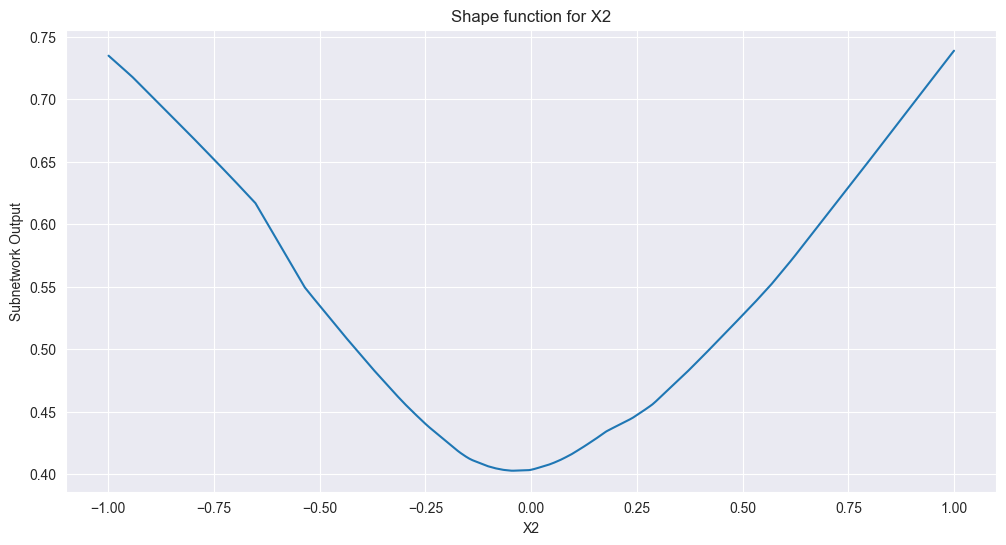

In [28]:
#-------------------------- view the shape function --------------------------
# get the output
main_output_layer = model_main_effect.get_layer("subnet_output")  # Get the subnet output layer
main_model = Model(inputs = model_main_effect.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_split)
main_output_weights = model_main_effect.get_layer("final_output").get_weights()[0]

# create the plot
var_name = "X2"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_split[var_index], 
             y = main_output_values[:,var_index]*main_output_weights[var_index].flatten())
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()